In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df=pd.read_csv('Space_Corrected.csv')

In [3]:
df=df.iloc[:,2:]

In [4]:
df.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [5]:
df['Status Rocket'] = df['Status Rocket'].str.replace('Status', '')

In [6]:
df[['Rocket Type', 'Payload']] = df['Detail'].str.split('|', expand=True)


In [7]:
def extract_state_country_center(location):
    parts = location.split(',')
    launch_center = parts[1].strip()
    country = parts[-1].strip()
    state = None
    if "USA" in country:
        state = parts[-2].strip().split()[-1].strip("()")
    # Return a pandas Series with state, country, and launch center
    return pd.Series([state, country, launch_center])

# Applying the function and assigning the results
df[['state', 'country', 'launch_center']] = df['Location'].apply(extract_state_country_center)


In [8]:
df['Rocket Type'].unique()

array(['Falcon 9 Block 5 ', 'Long March 2D ', 'Starship Prototype ',
       'Proton-M/Briz-M ', 'Atlas V 541 ', 'Long March 4B ',
       'Soyuz 2.1a ', 'Long March 5 ', 'H-IIA 202 ', 'Minotaur IV ',
       'Kuaizhou 11 ', 'Long March 3B/E ', 'Shavit-2 ', 'Electron/Curie ',
       'Long March 2C ', 'Long March 11 ', 'LauncherOne ',
       'Soyuz 2.1b/Fregat-M ', 'H-IIB ', 'Atlas V 501 ', 'Kuaizhou 1A ',
       'Long March 5B ', 'Qased ', 'Atlas V 551 ', 'Soyuz 2.1b/Fregat ',
       'Long March 7A ', 'Soyuz 2.1a/Fregat-M ', 'Ariane 5 ECA ',
       'Antares 230+ ', 'Atlas V 411 ', 'Simorgh ', 'Rokot/Briz KM ',
       'Proton-M/DM-3 ', 'Atlas V N22 ', 'Soyuz ST-A/Fregat-M ',
       'Long March 3B/YZ-1 ', 'New Shepard ', 'PSLV-QL ',
       'Long March 4C ', 'PSLV-XL ', 'Soyuz 2.1v/Volga ', 'Long March 6 ',
       'SARGE ', 'Pegasus XL ', 'Soyuz FG ', 'Safir-1B+ ',
       'Delta IV Medium+ (4,2) ', 'Jielong-1 ', 'Hyperbola-1 ',
       'GSLV Mk III ', 'Vega ', 'Falcon Heavy ', 'Long March 11H

In [9]:
mapping_df = pd.read_excel('Rocket Type.xlsx')

In [10]:
df = df.merge(mapping_df, on='Rocket Type', how='left')

In [11]:
df['Parsed Datum'] = pd.to_datetime(df['Datum'], format='%a %b %d, %Y %H:%M %Z', errors='coerce')

# Second attempt for those that failed to parse in the first attempt
mask = df['Parsed Datum'].isna()  # Mask for where the first parsing failed
df.loc[mask, 'Parsed Datum'] = pd.to_datetime(df.loc[mask, 'Datum'], format='%a %b %d, %Y', errors='coerce')

df['Datum']=df['Parsed Datum']
df.drop(columns=['Parsed Datum'], inplace=True)
# Extracting year, month, and season
df['Datum'] = pd.to_datetime(df['Datum'], utc=True).dt.tz_localize(None)

df['Year'] = df['Datum'].dt.year

df['Month'] = df['Datum'].dt.month_name()
df['Season'] = df['Datum'].dt.month % 12 // 3 + 1
df['Season'] = df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

df['Decade'] = (df['Year'] // 10) * 10  # Creating bins by decade


In [12]:
df[' Rocket'] = df[' Rocket'].str.strip()
df[' Rocket'] = df[' Rocket'].str.replace(',', '')
df[' Rocket'] = pd.to_numeric(df[' Rocket'])

### Check missing value counts

In [13]:
df.shape

(4328, 17)

In [14]:
df.isnull().sum()

Company Name          0
Location              0
Datum                 0
Detail                0
Status Rocket         0
 Rocket            3364
Status Mission        0
Rocket Type           0
Payload               0
state              2984
country               0
launch_center         0
Rocket Category       0
Year                  0
Month                 0
Season                0
Decade                0
dtype: int64

In [15]:
df_clean_rocketcost = df[' Rocket'].dropna()

## Data Visualization

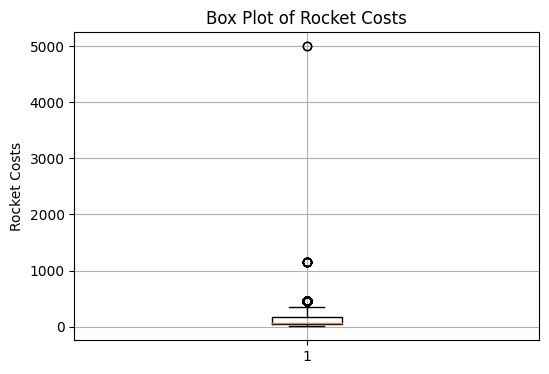

In [16]:
plt.figure(figsize=(6, 4))
plt.boxplot(df_clean_rocketcost)
plt.title('Box Plot of Rocket Costs')
plt.ylabel('Rocket Costs')
plt.grid(True)
plt.show()

In [17]:
df_clean_rocketcost.describe()

count     964.000000
mean      153.792199
std       288.450732
min         5.300000
25%        40.000000
50%        62.000000
75%       164.000000
max      5000.000000
Name:  Rocket, dtype: float64

In [18]:
#Remove Large values for better visualization
df_filtered = df_clean_rocketcost[df_clean_rocketcost<1000]

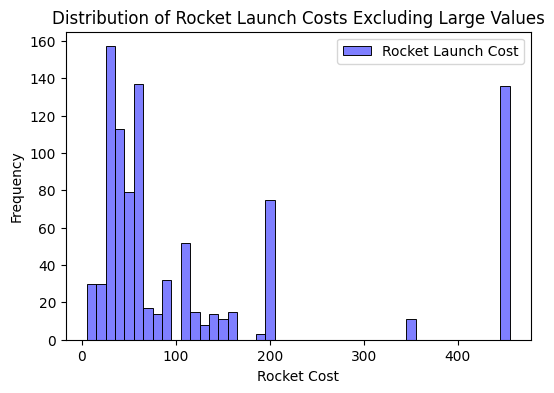

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df_filtered, color='blue', binwidth=10,
             label='Rocket Launch Cost', alpha=0.5)

# Adding a title and other labels
plt.title('Distribution of Rocket Launch Costs Excluding Large Values')
plt.xlabel('Rocket Cost')
plt.ylabel('Frequency')
plt.legend()  # Show the legend
plt.show()

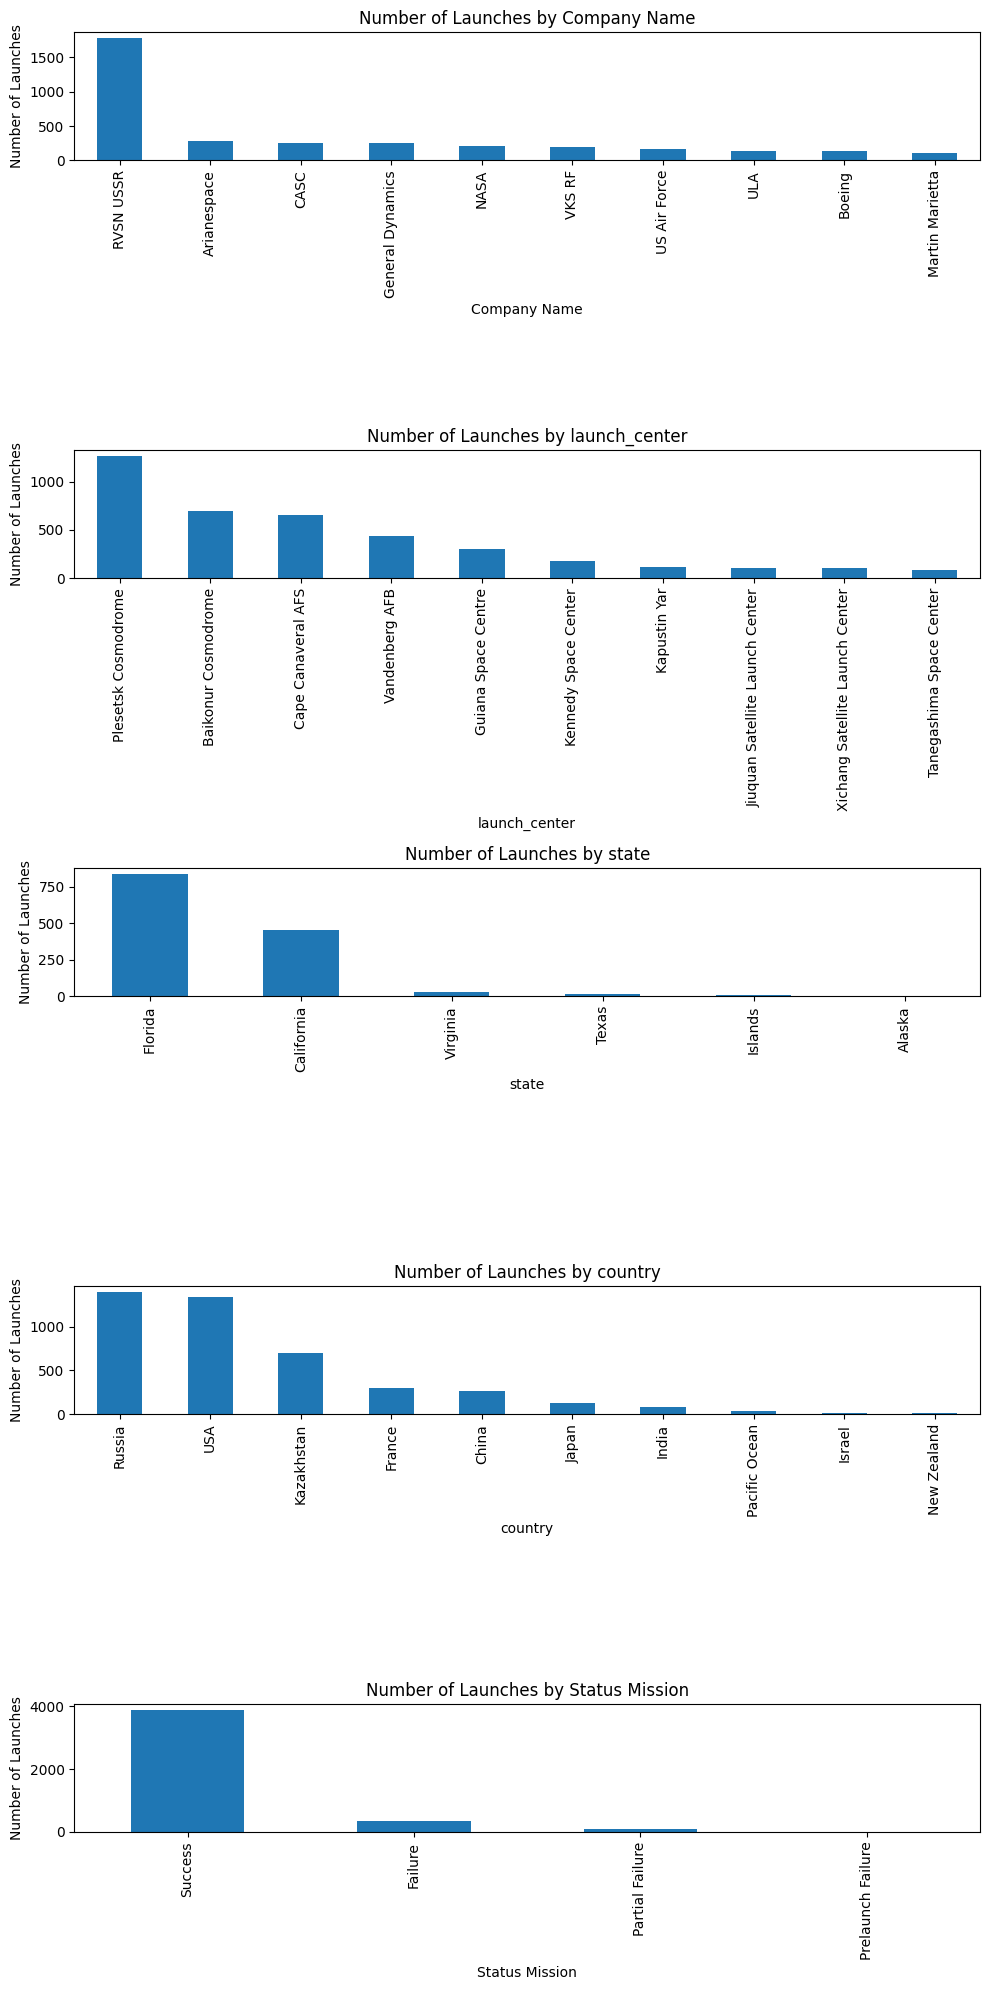

In [20]:
def create_bar_charts(dataframe, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 4 * len(columns)))

    if len(columns) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, column in zip(axes, columns):
        counts = dataframe[column].value_counts().head(10)
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Number of Launches by {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Number of Launches')

    plt.tight_layout()
    plt.show()

# Specify the columns to visualize
columns_to_visualize = ['Company Name','launch_center', 'state', 'country','Status Mission']

# Create bar charts
create_bar_charts(df, columns_to_visualize)

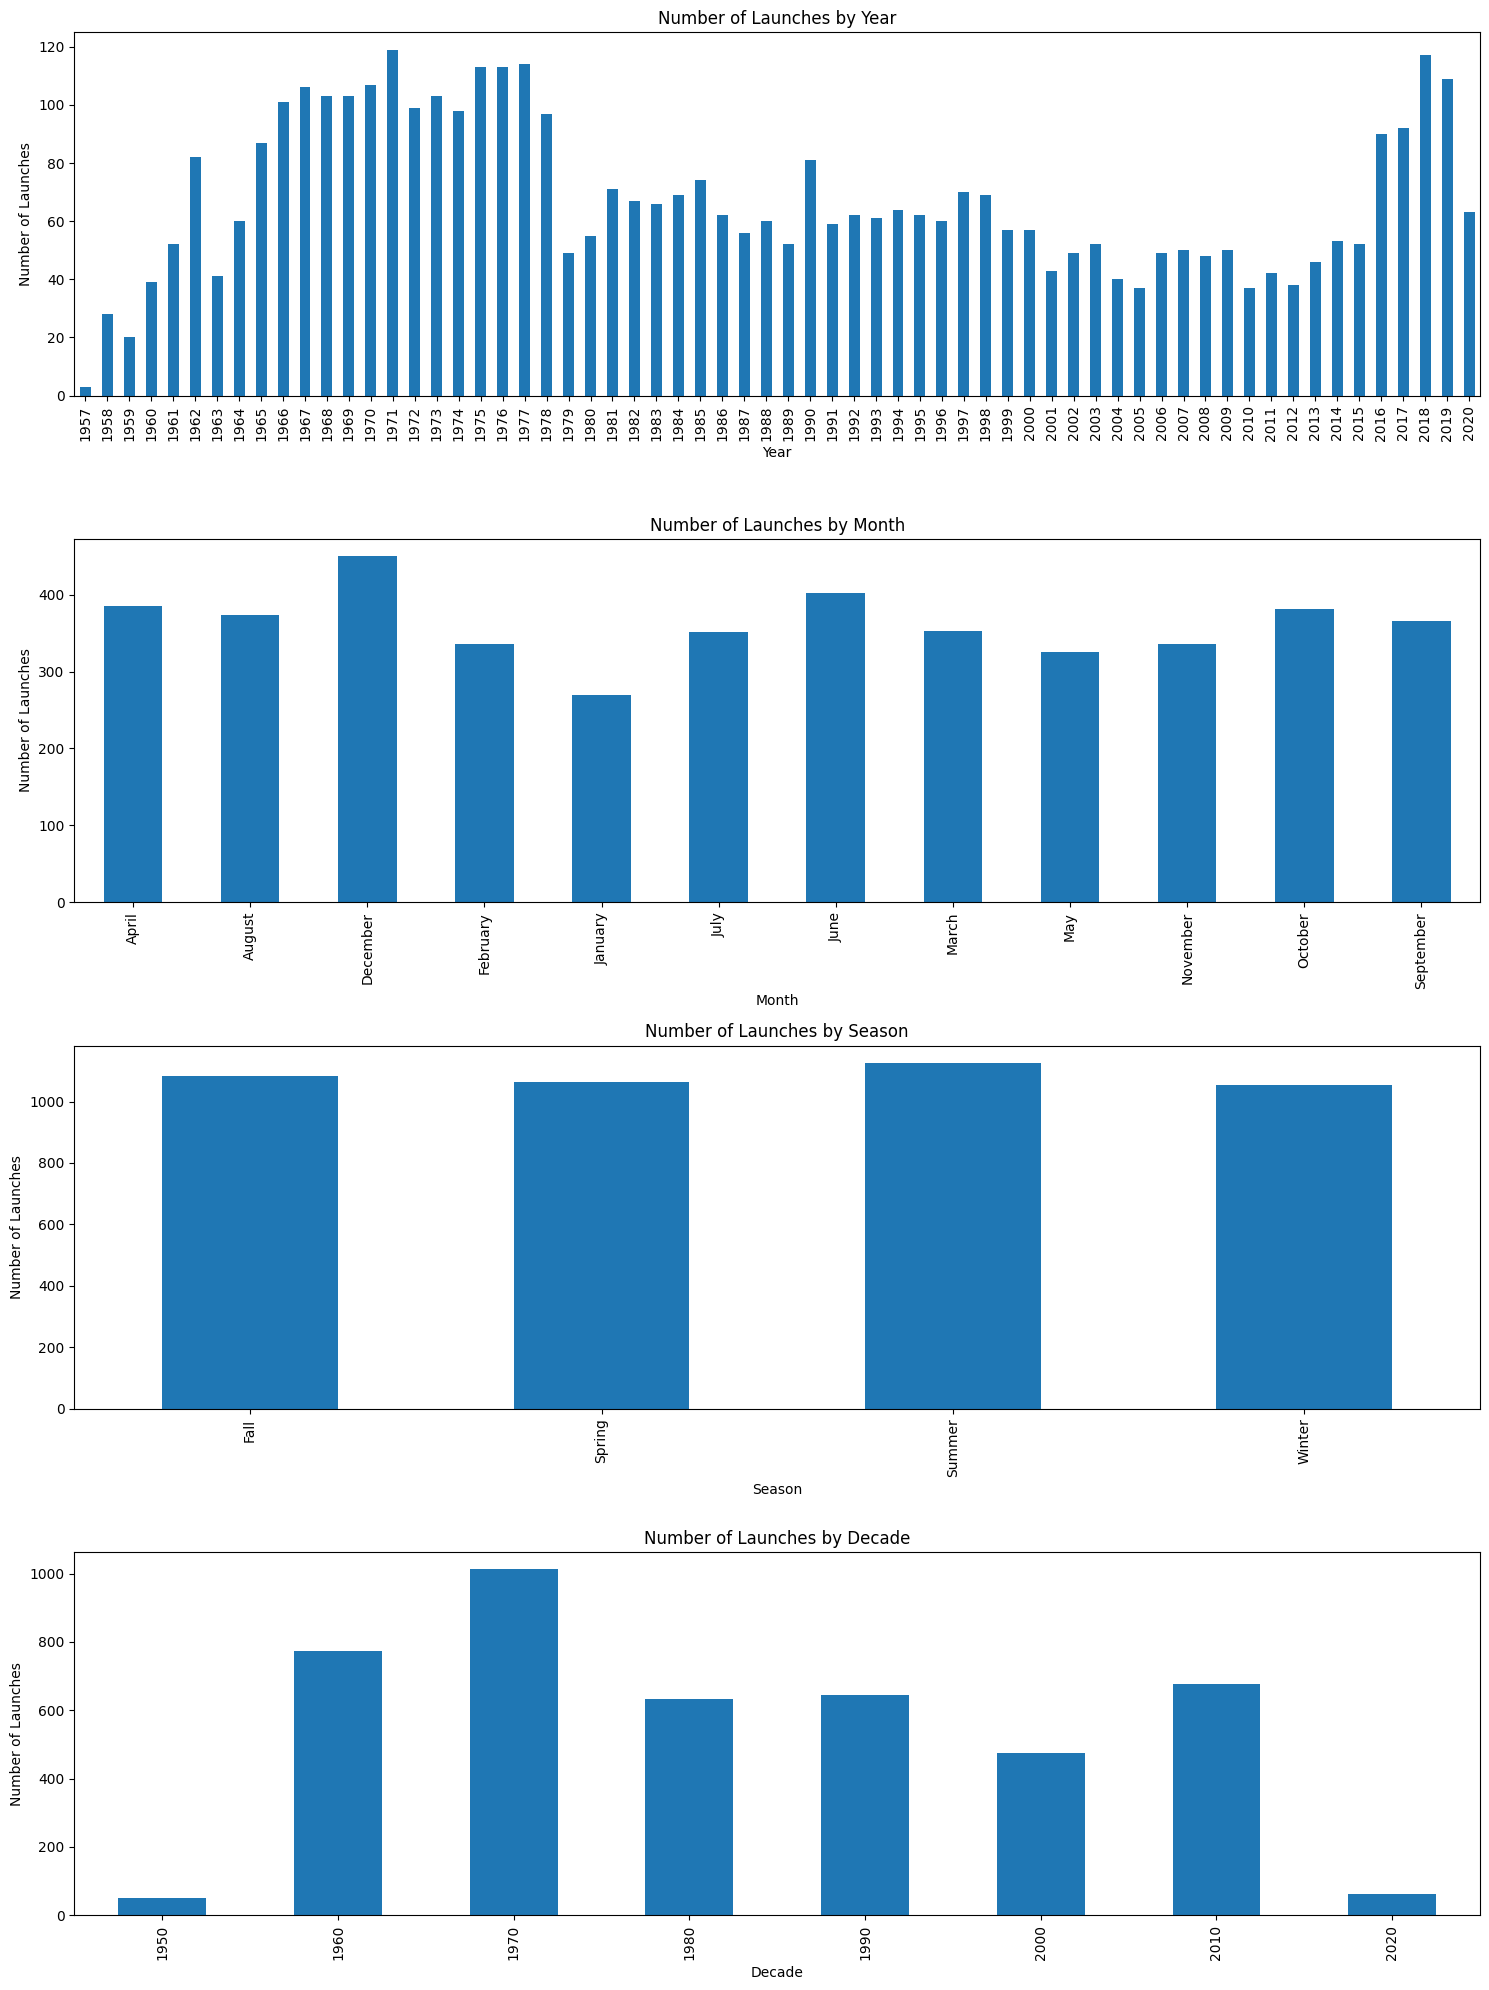

In [21]:
def create_time_bar_charts(dataframe, time_columns):
    fig, axes = plt.subplots(len(time_columns), 1, figsize=(15, 5 * len(time_columns)))

    if len(time_columns) == 1:
        axes = [axes]

    for ax, column in zip(axes, time_columns):
        counts = dataframe[column].value_counts().sort_index()
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Number of Launches by {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Number of Launches')

    plt.tight_layout()
    plt.show()

time_columns_to_visualize = ['Year', 'Month', 'Season','Decade']

# Create time-based bar charts
create_time_bar_charts(df, time_columns_to_visualize)

## Exploratory Data Analysis

In [22]:
from collections import Counter
col_counts = Counter(df['Status Mission'])

print(col_counts)


Counter({'Success': 3882, 'Failure': 340, 'Partial Failure': 102, 'Prelaunch Failure': 4})


### Imbalance dataset
We can find that most cases are successful, only few of the datasets are failure or partial failure. Since their are not only binary results, we can consider few possibility for future feature engineering. For example, make these value into numeric values, that is to say 1, 0.5, 0 , so to enable regression model. Other opportunity include binary, just success and not success, so as to enable classification model. We may explore and evaluate in the following week.

## Save Processed Datasets

In [23]:
df.to_csv('Processed Space Missions.csv', index=False)

In [24]:
df_filtered.to_csv('Space Missions For Cost Analysis.csv', index=False)